# Image Classification

tf.data.Dataset을 이용해 모델이 데이터를 효율적으로 활용할 수 있도록 구현해보는게 목적입니다.

기본적인 머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.


## Project 설명
### Task
* CIFAR 10 데이터셋을 이용해 classification을 진행해보자.
* [CIFAR 10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

### Baseline
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
    * 하이퍼파라미터 조절 (데이터 로드, 모델, Optimizer 등)
    * 모델 구성 변경 (layer의 갯수)
* Training
    * tf.data.Dataset 과 model.fit()을 사용

* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### 구글 드라이브 마운트
* Google의 Colab과 Drive를 이용해 노트북을 이용해 언제 어디서든 딥러닝 모델을 학습시켜보자.

In [3]:
# 코드 호환성을 위한 분기
use_colab = True
assert use_colab in [True, False]

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### 번외) GPU 서버를 어떻게 구성하면 좋을까?
1. 로컬 머신 (노트북, 데스크탑) 구매
    * GPU 노트북, 데스크탑, 서버 등 원하는 방법으로 다양하게 구비할 수 있다.
    * Colab과 다르게 세션이 종료되지않으며, 비교적 자유롭게 사용할 수 있다.
    * 원격 접속 및 오프라인 관리가 어려우며, 부수적인 유지보수 비용이 발생한다.

2. 클라우드 등 서버 사용
    * AWS, 네이버 클라우드 등
    * 오프라인 관리가 필요없으며, 안정적이다.
    * 비싸다...

### import packages

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import os

tf.__version__

'2.10.0'

### load data
* CIFAR 10 dataset을 로드한다. (npy)
* 학습에 사용되는 대표적인 데이터셋들은 프레임워크내 코드로 제공된다.

```
tf.keras.dataset.cifar10
tf.keras.dataset.cifar100
tf.keras.dataset.mnist
tf.keras.dataset.fashion_mnist
tf.keras.dataset.imdb

```

* 다양한 데이터셋을 쉽게 가져와 사용할 수 있다.

### 데이터셋 사용방법
* Data split
    * sklearn (머신러닝 프레임워크)를 이용해 데이터를 손쉽게 나눌 수 있다.

```
test_data_split, valid_data, test_labels_split, valid_labels = \
    train_test_split(test_data, test_labels, test_size=0.2, shuffle=True)
```

* test_size를 조절해 원하는 크기만큼의 데이터를 분리해 사용할 수 있다.

In [6]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.cifar10.load_data()

In [7]:
!cd /root/.keras/datasets/ && ls -al

zsh:cd:1: no such file or directory: /root/.keras/datasets/


In [8]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(test_labels[0]) # 데이터셋 제작할때, [3] => 3 으로 데이터 형태를 변경해줘야합니다.

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
[3]


In [9]:
test_data, valid_data, test_labels, valid_labels = \
    train_test_split(test_data, test_labels, test_size=0.1, shuffle=True) # 0~1의 값으로 줍니다.
                     # test_size => 0.1 = 10%
                     # test_size => 0.2 = 20%

# raw data normalization
# RGB 값이 0~255 사이 값인 것을 이용해 Normalization 진행
train_data = train_data / 255.
train_data = train_data.reshape([-1, 32, 32, 3])
train_labels = train_labels.reshape([-1]) #

valid_data = valid_data / 255.
valid_data = valid_data.reshape([-1, 32, 32, 3])
valid_labels = valid_labels.reshape([-1])

test_data = test_data / 255.
test_data = test_data.reshape([-1, 32, 32, 3])
test_labels = test_labels.reshape([-1])


In [10]:
# [데이터수, 32, 32, 3] [데이터수,]
print(train_data.shape, train_labels.shape)
print(valid_data.shape, valid_labels.shape)
print(test_data.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(1000, 32, 32, 3) (1000,)
(9000, 32, 32, 3) (9000,)


### dataset 구성
* tf.data.Dataset을 이용해 데이터셋을 구성한다.
    * 위에서 불러온 raw data (cifar10) 데이터셋을 모델이 학습 할 수 있도록 전달해 주는 데이터셋이다.
* tf data Dataset을 사용해야하는 이유?
    * 직접 Generator를 작성할 필요가 없다
    * map 함수를 이용해 전처리 과정을 직접 조절할 수 있다.
    * 메모리에 부담이 되지 않게 동작한다.


### 직접 적용해보자
* map 함수를 적용할 함수 구현 후 dataset을 구현하며 사용해보자

In [11]:
def one_hot_label(image, label): # label => one_hot
  label = tf.one_hot(label, depth=10)
  return image, label

* 위 one_hot_label 함수는 아래와 같이 동작한다.
# one_hot vector 예시

```Python
tf.one_hot(
    indices, depth, on_value=None, off_value=None, axis=None, dtype=None, name=None
)

indices = [0, 1, 2]
depth = 3
tf.one_hot(indices, depth)  # output: [3 x 3]
# [[1., 0., 0.],
#  [0., 1., 0.],
#  [0., 0., 1.]]

```

### map 함수를 포함한 dataset 구성
* Dataset을 딥러닝 데이터를 쉽게 불러오기 위한 일종의 Generator 입니다.
* 학습에 사용할 데이터셋은 총 3개
    * Train dataset, Valid dataset, Test dataset 입니다.
        * Raw data에서 분리한 데이터들
    * 데이터셋은 tf.data.Dataset으로 구성되며, 구현 파트에선 데이터를 불러오는 형식만을 지정해준다.
        * shuffle, batch 옵션을 이용해 다양하게 데이터를 로드해올 수 있다.
    

In [12]:
batch_size = 32

In [13]:
# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.map(one_hot_label) # 함수의 이름을 써서 구현
train_dataset = train_dataset.shuffle(10000).repeat().batch(batch_size=batch_size)
print(train_dataset)

# # for valid
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

# # for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


Metal device set to: Apple M1


2023-12-28 19:04:06.705622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-28 19:04:06.708878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>



* 데이터 타입의 경우 Tensorflow 버전에 따라 tf.float32 or tf.float64로 출력될 수 있으나 학습에 큰 영향을 주진 않는다.
* 해당 자료형은 tf.cast를 이용해 따로 타입을 지정해줄 수 있다.

### Save point 설정
* Model weight를 저장할 폴더를 지정한다.
* 폴더가 없다면 새로 생성해준다.

In [14]:
# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/cifar10_classification/exp1'
else:
    checkpoint_dir = 'cifar10_classification/exp1'

if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Model Savepoints
* 모델 저장시 모델의 파라미터를 저장한다.
    * 위에 구현된 모델의 shape을 기준으로 파라미터만 저장
* 저장된 데이터는 checkpoint 형태로 저장되며, load data를 이용해 불러올 수 있다.
    * 저장된 모델 데이터를 불러올 시에는 저장된 모델과 같은 shape인 모델이 메모리 상에 있어야 한다.

```
model = model() # 구현했던 모델
model.load_weights(checkpoint_dir)
```

### 데이터 확인
* 학습에 사용할 데이터를 확인해보자.

label = 9


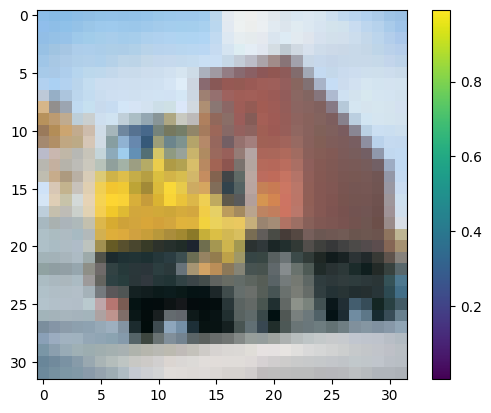

In [15]:
index = 219 # index를 변경해 확인해보자 (0~49999)
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(32, 32, 3))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

### 모델 구성
* 직접 모델을 구현해 봅시다.

In [41]:
class Conv(tf.keras.Model):
    def __init__(self,num_filters, kernel_size = 3):
        super(Conv, self).__init__()# 재료창고
        self.conv1 = layers.Conv2D(num_filters, kernel_size, padding ='same')
        self.conv2 = layers.Conv2D(num_filters, kernel_size, padding ='same')
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()


    def call(self, inputs, training = True):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = layers.Activation('relu')(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = layers.Activation('relu')(x)

        return x

class Dens(tf.keras.Model):
    def __init__(self,num_nodes_1 = 1024):
        super(Dens, self).__init__()
        self.dense1 = layers.Dense(num_nodes_1, kernel_initializer=tf.keras.initializers.HeUniform(),
                                   kernel_regularizer=tf.keras.regularizers.L2(0.0001))
        self.dense2 = layers.Dense(num_nodes_1, kernel_initializer=tf.keras.initializers.HeUniform(),
                                   kernel_regularizer=tf.keras.regularizers.L2(0.0001))
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs, training = True):
        x = self.dense1(inputs)
        x = self.bn1(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.5)(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = layers.Activation('relu')(x)
        
        return x

class VGGlikeModel(tf.keras.Model):
    def __init__(self):
        super(VGGlikeModel,self).__init__()
        self.conv_block1 = Conv(32)
        self.conv_block2 = Conv(64)
        self.conv_block3 = Conv(128)
        self.conv_block4 = Conv(256)
        self.fc = Dens()
        self.out = layers.Dense(10)

    def call(self, inputs, training = True):
        x = self.conv_block1(inputs)
        x = layers.MaxPooling2D()(x)
        x = self.conv_block2(x)
        x = layers.MaxPooling2D()(x)
        x = self.conv_block3(x)
        x = layers.MaxPooling2D()(x)
        x = self.conv_block4(x)
        x = layers.Flatten()(x)
        x = self.fc(x)
        x = self.out(x)
        return x



In [42]:
input_tensor = layers.Input(shape=(32, 32, 3,))
VGG = VGGlikeModel()

output_tensor = VGG.call(input_tensor)

model = tf.keras.Model(input_tensor, output_tensor)

# convolution = Conv(64)
# x = layers.Conv2D(128, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(input_tensor)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.1)(x)

# x = layers.MaxPool2D((2,2))(x)

# x = layers.Conv2D(128, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Conv2D(128, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.2)(x)

# x = layers.MaxPool2D((2,2))(x)

# x = layers.Conv2D(256, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Conv2D(256, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Conv2D(256, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.3)(x)

# x = layers.MaxPool2D((2,2))(x)

# x = layers.Conv2D(512, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Conv2D(512, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Conv2D(512, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.4)(x)
# x = layers.MaxPool2D((2,2))(x)

# x = layers.Conv2D(512, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Conv2D(512, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Conv2D(512, 3, padding='same',
#                   kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.MaxPool2D((2,2))(x)

# x = layers.Flatten()(x)

# x = layers.Dense(4096,
#                  kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(4096,
#                  kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(1000,
#                  kernel_initializer=tf.keras.initializers.HeUniform())(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)



# output_tensor = layers.Dense(10)(x)

# model = tf.keras.Model(input_tensor, output_tensor)

* 모델이 잘 생성 되었는지 간단하게 테스트해 봅시다.

In [44]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy()) # 총 10개의 데이터가 나오면 모델이 잘 구성된겁니다.

Predictions:  [[ 0.00169812 -0.00533592  0.00477646 -0.00623731 -0.01166814 -0.00372864
   0.0123824  -0.00300789 -0.00492118 -0.00152045]]


* 위 Predictions 결과가 총 10개 짜리 리스트로 출력 된다면, 현재 테스크에서 정상적인 출력입니다.
    * cifar10 dataset은 정답이 총 10개로 이뤄져 있습니다.
    * 출력값은 마지막 output layer에 activation의 유무에 따라서 값이 달라지며, activation을 통과하기전 데이터를 logit이라고 이야기합니다.

### Model compile
* 학습을 위한 Optimizer와 Loss fn을 설정해준다.
    * Optimzier는 learning rate를 인자로 가지며, 모델의 학습정도를 컨트롤합니다.
    * Loss fn은 모델의 예측결과와 실제 정답간의 차이를 loss로 계산해 모델을 학습합니다.

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(), # learning rate가 기본값으로 1e-3으로 들어가있습니다.
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv_40 (Conv)              (None, 32, 32, 32)        10400     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv_41 (Conv)              (None, 16, 16, 64)        55936     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv_42 (Conv)              (None, 8, 8, 128)         222464

In [47]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, # save point dir
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [48]:
max_epochs = 20

# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_data) // batch_size, # train data의 길이 // batch 길이
                    epochs=max_epochs,
                    validation_data=valid_dataset,
                    validation_steps=len(valid_data) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/20


2023-12-28 19:21:54.862774: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-28 19:21:54.865474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - ETA: 0s - loss: 1.6900 - accuracy: 0.5292

2023-12-28 19:23:25.982561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.62548, saving model to ./drive/My Drive/train_ckpt/cifar10_classification/exp1
1562/1562 [==============================] - 93s 54ms/step - loss: 1.6900 - accuracy: 0.5292 - val_loss: 1.6255 - val_accuracy: 0.5403
Epoch 2/20
1562/1562 [==============================] - ETA: 0s - loss: 1.0740 - accuracy: 0.7004
Epoch 2: val_loss improved from 1.62548 to 1.20640, saving model to ./drive/My Drive/train_ckpt/cifar10_classification/exp1
1562/1562 [==============================] - 77s 49ms/step - loss: 1.0740 - accuracy: 0.7004 - val_loss: 1.2064 - val_accuracy: 0.6593
Epoch 3/20
1562/1562 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.7597
Epoch 3: val_loss improved from 1.20640 to 0.86163, saving model to ./drive/My Drive/train_ckpt/cifar10_classification/exp1
1562/1562 [==============================] - 81s 52ms/step - loss: 0.8610 - accuracy: 0.7597 - val_loss: 0.8616 - val_accuracy: 0.7571
Epoch 4/20
1562/1562 [========

### 학습 결과를 정리해봅시다.
* Model 학습을 진행하며 저장된 결과를 전달 받은 history 객체를 이용해 학습 과정을 출력해봅시다.

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

NameError: name 'history' is not defined

### 모델 평가
* Model 학습 후 저장된 weight를 다시 불러와 테스트를 진행합니다.
    * 학습이 진행되며, 가장 낮은 val-loss를 이용해 모델을 저장했기 때문에 가장 작은 val-loss를 가지는 곳의 파라미터가 저장되어 있습니다.


In [ ]:
model.load_weights(checkpoint_dir)

* 모델 파라미터를 불러온 후 테스트 데이터셋을 이용해 평가를 진행합니다.
* 가장 기본적인 Accuracy를 제공합니다.

In [ ]:
results = model.evaluate(test_dataset, steps=len(test_data) // batch_size)

In [ ]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

In [ ]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(32, 32, 3))
  p.axis('off')

### 평가 메트릭을 설정해보자
* 인공지능 모델을 이용해 문제를 해결할 시에 해당 분야에서 고유하게 사용하던 평가 메트릭 혹은 새로운 메트릭이 사용되기도 합니다.
* Classification에서 사용되었던 평가 지표를 사용해봅시다.



## Measuring final score
* 모델 평가 지표

### \begin{equation*} M = 50(P + min(\frac{1}{S}, 1)) \end{equation*}

* P : Model-accuracy
* S : Size of model (MB)


### \begin{equation*} S = \frac{Parameters * float_{size}}{MB} \end{equation*}
\begin{equation*} = \frac{M_p * 32} {1024^2} \end{equation*}



* 해당 지표는 분류 평가를 위한 내용이며, 모델의 크기에 따른 정확도를 나타내는 지표입니다.

In [ ]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(results[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (results[1] + min((1/s), 1))

    print("score : " + str(score))

### 스코어 결과
* 위의 스코어는 분류모델에 적용되는 스코어입니다.
* 모델의 크기 (MB) 와 정확도를 이용해 스코어를 출력합니다.
    * 40 이상의 스코어에 도전해보세요!

In [ ]:
final_score()

### 추가 과제
* 높은 스코어를 달성하신 분들께선 더 맞추기 어려운 데이터셋으로 도전해보세요.

```
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.cifar100.load_data()
```

* 데이터 로드 파트에서 위 코드를 고치면 더 세분화된 분류를 진행하는 데이터셋을 사용할 수 있습니다.